In [ ]:
 from google.colab import drive
 import os

!pip install pyspark
!pip install --upgrade tensorflow_hub
!pip install --upgrade tensorflow_text
!pip install --upgrade transformers

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

spark = SparkSession.builder.getOrCreate()


In [ ]:
# Import the necessary libraries
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
import functools
import transformers
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertModel


****Mount notebook in your Google Drive****

In [ ]:
# README - Execute this cell to mount the notebook in your google drive. 
# Exxdecute the cell and follow the link to sign and, paste the given key in the little text box. The credentials are only available for you. 
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

#os.mkdir("/content/drive/MyDrive/stsbenchmark")
#os.chdir("/content/drive/MyDrive/stsbenchmark")
#!git clone https://github.com/emilstahl97/stsbenchmark.git
#!git pull


In [ ]:
schema = StructType([
    StructField("genre", StringType(), True),
    StructField("filename", StringType(), True),
    StructField("year", StringType(), True),
    StructField("year_id", IntegerType(), True),
    StructField("score", FloatType(), True),
    StructField("sentence1", StringType(), True),
    StructField("sentence2", StringType(), True)])

# get the datasets from drive
train = spark.read.csv("/content/drive/MyDrive/stsbenchmark/stsbenchmark/sts-train.csv", sep ='\t', header=False, schema=schema)
test = spark.read.csv("/content/drive/MyDrive/stsbenchmark/stsbenchmark/sts-test.csv", sep ='\t', header=False, schema=schema)
dev = spark.read.csv("/content/drive/MyDrive/stsbenchmark/stsbenchmark/sts-dev.csv", sep ='\t', header=False, schema=schema)


train.show()
test.show()
dev.show()

+-------------+--------+--------+-------+-----+--------------------+--------------------+
|        genre|filename|    year|year_id|score|           sentence1|           sentence2|
+-------------+--------+--------+-------+-----+--------------------+--------------------+
|main-captions|  MSRvid|2012test|      1|  5.0|A plane is taking...|An air plane is t...|
|main-captions|  MSRvid|2012test|      4|  3.8|A man is playing ...|A man is playing ...|
|main-captions|  MSRvid|2012test|      5|  3.8|A man is spreadin...|A man is spreadin...|
|main-captions|  MSRvid|2012test|      6|  2.6|Three men are pla...|Two men are playi...|
|main-captions|  MSRvid|2012test|      9| 4.25|A man is playing ...|A man seated is p...|
|main-captions|  MSRvid|2012test|     11| 4.25|Some men are figh...|Two men are fight...|
|main-captions|  MSRvid|2012test|     12|  0.5|   A man is smoking.|   A man is skating.|
|main-captions|  MSRvid|2012test|     13|  1.6|The man is playin...|The man is playin...|
|main-capt

## **Normalize score column of each dataset**

In [ ]:
train = train.withColumn("score", col("score")/2.5-1)
test = test.withColumn("score", col("score")/2.5-1)
dev = dev.withColumn("score", col("score")/2.5-1)

dev.select("score").describe().show()

+-------+--------------------+
|summary|               score|
+-------+--------------------+
|  count|                1500|
|   mean|-0.05443697837591158|
| stddev|  0.6001942581590352|
|    min|                -1.0|
|    max|                 1.0|
+-------+--------------------+



## **Tokenize** 

In [ ]:
from itertools import repeat

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

max_array = 200

def tokenize(text):
    array = np.array(tokenizer(text or "", return_tensors='tf', padding=True)["input_ids"][0]).tolist()
    diff = max_array - len(array)
    if(diff>0):
        array = array + list(repeat(0, diff))
    elif(diff<0):
        array = array[0:max_array]
    return array

tokenizeUDF = udf(lambda text: tokenize(text), ArrayType(IntegerType())) 

train = train.withColumn("sentence1_tokenized", tokenizeUDF(col("sentence1")))
train = train.withColumn("sentence2_tokenized", tokenizeUDF(col("sentence2")))
test = test.withColumn("sentence1_tokenized", tokenizeUDF(col("sentence1")))
test = test.withColumn("sentence2_tokenized", tokenizeUDF(col("sentence2")))
dev = dev.withColumn("sentence1_tokenized", tokenizeUDF(col("sentence1")))
dev = dev.withColumn("sentence2_tokenized", tokenizeUDF(col("sentence2")))


print(train.select("sentence2_tokenized").collect()[1])

Row(sentence2_tokenized=[101, 1037, 2158, 2003, 2652, 1037, 8928, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


## **Input Layer**

In [ ]:
input_ids_1 = tf.keras.layers.Input(shape=(1,), dtype=tf.int32, name='input_ids_1')
input_ids_2 = tf.keras.layers.Input(shape=(1,), dtype=tf.int32, name='input_ids_2')

## **BERT encoder layer**

In [ ]:
transformers.logging.set_verbosity_error() # to not show warnings

output_1 = TFBertModel.from_pretrained("bert-base-uncased", trainable=True, name="bert_1")(input_ids=input_ids_1)
output_2 = TFBertModel.from_pretrained("bert-base-uncased", trainable=True, name="bert_2")(input_ids=input_ids_2)

## **Pooled output**

In [ ]:
pooled_1 = tf.reduce_mean(output_1.last_hidden_state, 1, name="pool_1")
pooled_2 = tf.reduce_mean(output_2.last_hidden_state, 1, name="pool_2")

### **Regression**

## **Cosine similarity**

In [ ]:
cos_distance = tf.keras.layers.Dot(axes=1, normalize=True, name="cosine_sim")([pooled_1, pooled_2])

##**Model**

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids_1 (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 input_ids_2 (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 bert_1 (TFBertModel)           TFBaseModelOutputWi  109482240   ['input_ids_1[0][0]']            
                                thPoolingAndCrossAt                                               
                                tentions(last_hidde                                               
                                n_state=(None, None                                           

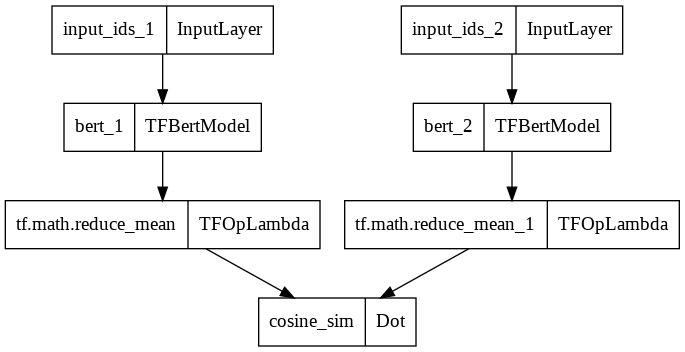

In [ ]:
regression_model = tf.keras.Model(inputs=[input_ids_1, input_ids_2], outputs=[cos_distance])

regression_model.summary()
tf.keras.utils.plot_model(regression_model)


##**Compile**

In [ ]:
optimizer = tf.optimizers.Adam(0.001)
mse = tf.keras.losses.MeanSquaredError()
accuracy = tf.keras.metrics.Accuracy()

regression_model.compile(optimizer=optimizer, loss=mse, metrics=accuracy)

##**Training**

In [ ]:
df_train = train.select("sentence1_tokenized","sentence2_tokenized","score").toPandas()

sent_1 = tf.convert_to_tensor(df_train["sentence1_tokenized"].values.tolist(), dtype=tf.float32)
sent_2 = tf.convert_to_tensor(df_train["sentence2_tokenized"].values.tolist(), dtype=tf.float32)

regression_model.fit([sent_1,sent_2], df_train["score"], epochs=1)
#model.predict([encoded_input_1["input_ids"],encoded_input_2["input_ids"]])

##**Classification**

## **Concatenate sentences**

In [ ]:
num_labels = 2

diff = tf.keras.layers.Subtract()([pooled_1, pooled_2])
# pooled_1.shape[1] == number of features
weights = tf.Variable(tf.random.truncated_normal([pooled_1.shape[1], num_labels]))
multi = tf.matmul(diff, weights)
softmax = tf.nn.softmax(multi)


##**Model**

In [ ]:
classification_model = tf.keras.Model(inputs=[input_ids_1, input_ids_2], outputs=[softmax])

classification_model.summary()
tf.keras.utils.plot_model(classification_model)

##**Compile**

In [ ]:
optimizer = tf.optimizers.Adam(0.001)
mse = tf.keras.losses.CategoricalCrossentropy()
accuracy = tf.keras.metrics.Accuracy()

classification_model.compile(optimizer=optimizer, loss=mse, metrics=accuracy)

In [ ]:
text_test = ['this is such an amazing movie!']

tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')

text_preprocessed = preprocessing_layer(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

In [ ]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'

encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')

bert_results = encoder(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"][0].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

**Input Layer**

In [ ]:
input_ids_1 = tf.keras.layers.Input(shape=(1,), dtype=tf.int32, name='input_ids_1')
input_ids_2 = tf.keras.layers.Input(shape=(1,), dtype=tf.int32, name='input_ids_2')

**BERT encoder layer**

In [ ]:
transformers.logging.set_verbosity_error() # to not show warnings

output_1 = TFBertModel.from_pretrained("bert-base-uncased", trainable=True, name="bert_1")(input_ids=input_ids_1)
output_2 = TFBertModel.from_pretrained("bert-base-uncased", trainable=True, name="bert_2")(input_ids=input_ids_2)

**Pooled Output**

In [ ]:
pooled_1 = tf.reduce_mean(output_1.last_hidden_state, 1, name="pool_1")
pooled_2 = tf.reduce_mean(output_2.last_hidden_state, 1, name="pool_2")

*****Regression*****

In [ ]:
cos_distance = tf.keras.layers.Dot(axes=1, normalize=True, name="cosine_sim")([pooled_1, pooled_2])